In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
IDS2017URL = "/gdrive/MyDrive/IDS2017/IDS2017.csv"

In [3]:
import torch
import pandas as pd
import tensorflow as tf
import numpy as np
import torch.nn as nn
import random

from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torchvision import transforms

In [4]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(19)

In [5]:
def balance_data(X,y,seed):
  np.random.seed(seed)
  unique,counts = np.unique(y,return_counts=True)
  #unique
  #array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
  #counts
  #array([2357511,    1956,   41834,   10293,  230124,    5499,    5796, 7935,      11,      36,  158804,    5897,    2180])
  mean_samples_per_class = int(round(np.mean(counts)))
  N,D = X.shape
  new_X = np.empty((0,D))
  new_y = np.empty((0),dtype=int)
  for i,c in enumerate(unique):
      temp_x = X[y==c]
      indices = np.random.choice(temp_x.shape[0],mean_samples_per_class) # gets `mean_samples_per_class` indices of class `c`
      new_X = np.concatenate((new_X,temp_x[indices]),axis=0) # now we put new data into new_X 
      temp_y = np.ones(mean_samples_per_class,dtype=int)*c
      new_y = np.concatenate((new_y,temp_y),axis=0)
      indices = np.arange(new_y.shape[0])
      np.random.shuffle(indices)
      new_X =  new_X[indices,:]
      new_y = new_y[indices]
  return (new_X, new_y)

In [6]:
class IDSDataset(Dataset):

    def __init__(self, IDS2017URL, tranform=True):
      df = pd.read_csv(IDS2017URL)
      df.loc[df['Label'].isin([ 'Web Attack - Sql Injection','Web Attack - XSS', 'Web Attack - Brute Force']), 'Label'] = 'Web Attack'
      df = df[['Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Flow IAT Max', 'Bwd Packet Length Std', 'Fwd Packet Length Max', 'Flow Bytes/s', 'Total Length of Bwd Packets', 'Fwd Packet Length Mean', 'Flow Duration', 'Flow IAT Min', 'Total Length of Fwd Packets', 'Flow IAT Mean', 'Total Backward Packets', 'Bwd Packet Length Max', 'Flow Packets/s', 'Flow IAT Std', 'Fwd IAT Total', 'Bwd Packet Length Min', 'Fwd Packet Length Min', 'Label']]
      
      #df = df[~df['Label'].isin(['Heartbleed', 'Web Attack - Sql Injection', 'Infiltration', 'Web Attack - XSS', 'Web Attack - Brute Force'])]
      df = df.replace([-np.inf, np.inf], np.nan)
      df = df.dropna()
      #df.drop(df.columns[[37,39,61,62,63,64,65,66]],axis=1,inplace=True)
      self.X = df.iloc[:, :-1].apply(lambda x: (x-np.mean(x))/np.std(x)).values
      self.y = df.values[:, -1]
      
      le = LabelEncoder()
      le.fit(["BENIGN", "DoS Hulk", "PortScan", "DDoS", "DoS GoldenEye","FTP-Patator","SSH-Patator","DoS slowloris","DoS Slowhttptest","Web Attack","Bot","Infiltration","Heartbleed"])
      self.y = le.transform(self.y)
      self.X, self.y = balance_data(self.X, self.y, seed=2)
      self.X = self.X.astype('float32')
      print(self.y)


    def __len__(self):
      return len(self.X)
    
    def __getitem__(self, idx):
      return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 20)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(20, 20)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(20, 13)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)

    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)

        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)

        # output layer
        X = self.hidden3(X)
        X = self.act3(X)

        return X
 
def prepare_data(path):
    # load the dataset
    dataset = IDSDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=10000, shuffle=True)
    test_dl = DataLoader(test, batch_size=10000, shuffle=False)
    return train_dl, test_dl

def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    # enumerate epochs
    for epoch in range(4):
        # enumerate mini batches
        print(model.state_dict())
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            #torch.autograd.set_detect_anomaly(True)
            # compute the model output
            #print(inputs)
            #print("******************")
            yhat = model(inputs)
            #print(yhat)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            if i % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(train_dl.dataset),
                100. * i / len(train_dl), loss.item()))
            # print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, loss.item()))
            # running_loss = 0.0

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [7]:
# class IDSDataset(Dataset):

#     def __init__(self, IDS2017URL, tranform=True):
#       df = pd.read_csv(IDS2017URL)
#       df = df[~df['Label'].isin(['Heartbleed', 'Web Attack - Sql Injection', 'Infiltration', 'Web Attack - XSS', 'Web Attack - Brute Force'])]
#       df = df.replace([-np.inf, np.inf], np.nan)
#       df = df.dropna()
#       df = pd.concat([df.iloc[:,0:37], df[:,38:],df.iloc[:, -2:]], axis=1)
#       self.X = df.iloc[:, :-2].apply(lambda x: (x-np.mean(x))/np.std(x)+0.00001).values
#       self.y = df.values[:, -2]
#       self.X = self.X.astype('float32')
#       self.y = LabelEncoder().fit_transform(self.y)

#     def __len__(self):
#       return len(self.X)
    
#     def __getitem__(self, idx):
#       return [self.X[idx], self.y[idx]]
 
#     # get indexes for train and test rows
#     def get_splits(self, n_test=0.33):
#         # determine sizes
#         test_size = round(n_test * len(self.X))
#         train_size = len(self.X) - test_size
#         # calculate the split
#         return random_split(self, [train_size, test_size])

# class MLP(Module):
#     # define model elements
#     def __init__(self, n_inputs):
#         super(MLP, self).__init__()
#         # input to first hidden layer
#         self.hidden1 = Linear(n_inputs, 76)
#         #kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
#         self.act1 = ReLU()
#         # second hidden layer
#         self.hidden2 = Linear(76, 76)
#         #kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
#         self.act2 = ReLU()
#         # third hidden layer and output
#         self.hidden3 = Linear(76, 10)
#         #xavier_uniform_(self.hidden3.weight)
#         self.act3 = Softmax(dim=1)

#     def forward(self, X):
#         # input to first hidden layer
#         X = self.hidden1(X)
#         X = self.act1(X)
#         print(X)
#         # second hidden layer
#         X = self.hidden2(X)
#         X = self.act2(X)
#         print(X)
#         # output layer
#         X = self.hidden3(X)
#         X = self.act3(X)
#         print(X)
#         return X
 
# def prepare_data(path):
#     # load the dataset
#     dataset = IDSDataset(path)
#     # calculate split
#     train, test = dataset.get_splits()
#     # prepare data loaders
#     train_dl = DataLoader(train, batch_size=1000, shuffle=True)
#     test_dl = DataLoader(test, batch_size=1000, shuffle=False)
#     return train_dl, test_dl

# def train_model(train_dl, model):
#     # define the optimization
#     criterion = CrossEntropyLoss()
#     optimizer = Adam(model.parameters(), lr=0.0001)
#     # enumerate epochs
#     for epoch in range(10):
#         # enumerate mini batches
#         print(model.state_dict())
#         for i, (inputs, targets) in enumerate(train_dl):
#             # clear the gradients
#             optimizer.zero_grad()
#             #torch.autograd.set_detect_anomaly(True)
#             # compute the model output
#             #print(inputs)
#             #print("******************")
#             yhat = model(inputs)
#             #print(yhat)
#             # calculate loss
#             loss = criterion(yhat, targets)
#             # credit assignment
#             loss.backward()
#             # update model weights
#             optimizer.step()

# def evaluate_model(test_dl, model):
#     predictions, actuals = list(), list()
#     for i, (inputs, targets) in enumerate(test_dl):
#         # evaluate the model on the test set
#         yhat = model(inputs)
#         # retrieve numpy array
#         yhat = yhat.detach().numpy()
#         actual = targets.numpy()
#         # convert to class labels
#         yhat = argmax(yhat, axis=1)
#         # reshape for stacking
#         actual = actual.reshape((len(actual), 1))
#         yhat = yhat.reshape((len(yhat), 1))
#         # store
#         predictions.append(yhat)
#         actuals.append(actual)
#     predictions, actuals = vstack(predictions), vstack(actuals)
#     # calculate accuracy
#     acc = accuracy_score(actuals, predictions)
#     return acc

# def predict(row, model):
#     # convert row to data
#     row = Tensor([row])
#     # make prediction
#     yhat = model(row)
#     # retrieve numpy array
#     yhat = yhat.detach().numpy()
#     return yhat

In [8]:
train_dl, test_dl = prepare_data(IDS2017URL)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[ 4  6  2 ...  5 10  8]


In [9]:
train_dl.dataset

In [10]:
print(len(train_dl.dataset), len(test_dl.dataset))

1894678 933199


In [11]:
model = MLP(19)

In [12]:
train_model(train_dl, model)

OrderedDict([('hidden1.weight', tensor([[ 4.3708e-02, -2.6401e-01, -1.4147e-01, -3.5152e-01, -2.1487e-01,
         -4.5043e-01, -2.8713e-01, -1.0456e-01, -1.9378e-01, -2.7206e-01,
         -1.7781e-01, -1.0152e-01,  2.2577e-01,  2.3655e-01,  1.4220e-01,
         -3.8710e-01,  2.5107e-01, -4.3265e-01, -4.4896e-01],
        [-2.1098e-01, -1.0824e-01,  4.0096e-01,  2.4272e-01,  4.3802e-02,
         -8.1274e-02, -4.8923e-01, -2.6946e-01,  1.1173e-02, -3.9400e-01,
         -1.2877e-01, -2.7328e-01, -2.2684e-01,  2.1197e-01, -4.3739e-01,
          1.3195e-01,  5.2679e-01, -3.5781e-01,  7.6137e-02],
        [ 1.1418e-01, -3.5647e-01, -4.4265e-01, -5.3883e-01, -5.0165e-01,
         -4.5182e-02,  1.0992e-01,  2.7490e-01,  1.1037e-01,  9.5280e-02,
         -7.7786e-02,  3.0529e-01,  1.1635e-01,  5.0539e-01,  2.6515e-01,
         -2.9331e-02, -8.1325e-02,  2.5729e-02, -1.6086e-01],
        [ 2.5805e-01, -1.9802e-01,  2.9973e-01, -1.3390e-01, -5.4929e-01,
         -2.1358e-01, -1.1801e-01,  3.4997

In [13]:
!pip install shap

     |████████████████████████████████| 358kB 9.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=e6bf158dcf6fb5dd9ba7844fd1bb072d8a116492b4f36cbc322ea0ceea0c788b
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [14]:
import shap

In [15]:
df = pd.read_csv(IDS2017URL)
df.loc[df['Label'].isin([ 'Web Attack - Sql Injection','Web Attack - XSS', 'Web Attack - Brute Force']), 'Label'] = 'Web Attack'
df = df[['Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Flow IAT Max', 'Bwd Packet Length Std', 'Fwd Packet Length Max', 'Flow Bytes/s', 'Total Length of Bwd Packets', 'Fwd Packet Length Mean', 'Flow Duration', 'Flow IAT Min', 'Total Length of Fwd Packets', 'Flow IAT Mean', 'Total Backward Packets', 'Bwd Packet Length Max', 'Flow Packets/s', 'Flow IAT Std', 'Fwd IAT Total', 'Bwd Packet Length Min', 'Fwd Packet Length Min', 'Label']]
#df = df[~df['Label'].isin(['Heartbleed', 'Web Attack - Sql Injection', 'Infiltration', 'Web Attack - XSS', 'Web Attack - Brute Force'])]
df = df.replace([-np.inf, np.inf], np.nan)
df = df.dropna()


Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.


In [16]:
train_dl

In [17]:
train_iter = iter(train_dl)

In [18]:
images, labels = train_iter.next()

In [19]:
px =images.numpy()
#px = pd.DataFrame(px)

In [20]:
px

array([[-0.25203905, -0.21300471, -0.22273196, ..., -0.21935199,
        -0.5965232 , -0.3103172 ],
       [-0.30217156, -0.24519348, -0.37563038, ..., -0.43161044,
        -0.5094167 , -0.2771801 ],
       [-0.06516121,  0.21855125,  3.6455884 , ...,  2.5008402 ,
        -0.5965232 , -0.3103172 ],
       ...,
       [-0.31291422, -0.24519348, -0.15316051, ..., -0.2695128 ,
        -0.5965232 , -0.3103172 ],
       [-0.2806862 , -0.24519348, -0.22884394, ..., -0.3245552 ,
        -0.5965232 , -0.21090591],
       [-0.24666771, -0.20951387, -0.24957325, ..., -0.24881847,
        -0.5965232 , -0.3103172 ]], dtype=float32)

In [21]:
px[:1]

array([[-0.25203905, -0.21300471, -0.22273196, -0.3822578 , -0.25616693,
        -0.05750505, -0.00706244, -0.25203905, -0.14613862, -0.05506563,
        -0.04479132, -0.19294222,  0.00460574, -0.43023267, -0.27848864,
        -0.22304328, -0.21935199, -0.5965232 , -0.3103172 ]],
      dtype=float32)

In [22]:
e = shap.DeepExplainer(
        model, 
        torch.from_numpy(
            px[np.random.choice(np.arange(len(px)), 10000, replace=False)]
        ))

In [45]:
shap_values[12]

array([[-2.20159385e-02, -2.21774355e-02,  4.40779626e-02, ...,
         7.84028769e-02,  6.86080800e-03, -1.15555502e-03],
       [ 6.27596397e-04,  2.37998538e-04, -1.47335203e-02, ...,
        -4.45185433e-04, -5.93723403e-03,  1.04306289e-03],
       [ 1.04903360e-03,  5.46080002e-04, -1.24218464e-02, ...,
         3.44496919e-03, -5.03901904e-03,  1.13192888e-03],
       ...,
       [-4.09106833e-05, -2.06253462e-04,  4.64951627e-05, ...,
        -1.62055511e-02, -1.07491542e-05, -4.23524252e-05],
       [ 1.49252184e-04,  4.04672319e-05, -4.54541150e-04, ...,
        -1.19688213e-02,  7.49768969e-06,  3.56239161e-06],
       [ 8.12757004e-04,  3.77269113e-04, -1.53241931e-02, ...,
         8.46348848e-05, -3.40907827e-05,  1.06767693e-03]])

In [24]:
x_samples = px[np.random.choice(np.arange(len(px)), 300, replace=False)]
print(len(x_samples))
shap_values = e.shap_values(
    torch.from_numpy(x_samples)
)

300


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [38]:
 np.mean(np.abs(shap_values), axis=0).shape

(300, 19)

In [48]:
len(shap_values) # class

13

In [49]:
len(shap_values[0]) #samples

300

In [50]:
len(shap_values[0][0]) #fearures

19

In [51]:
test = np.abs(shap_values)

In [54]:
np.mean(np.abs(shap_values[0]), axis=0)

array([0.01167525, 0.00992163, 0.03839032, 0.02784389, 0.03155392,
       0.02172191, 0.01265483, 0.02618734, 0.06003693, 0.02380211,
       0.01551474, 0.05568058, 0.00272051, 0.07516581, 0.03234024,
       0.03888505, 0.06569242, 0.05068871, 0.02503202])

In [56]:
test=np.abs(shap_values[0])

In [57]:
test

array([[1.24468002e-03, 8.12757295e-04, 2.08002492e-03, ...,
        3.11319670e-03, 1.60297826e-02, 3.07628093e-03],
       [1.21800054e-03, 1.50442100e-03, 4.90187667e-03, ...,
        5.60043799e-03, 2.14712191e-02, 1.06274998e-02],
       [5.04278345e-03, 1.27014183e-02, 2.70893145e-03, ...,
        8.94279871e-03, 8.02187622e-02, 4.10138816e-02],
       ...,
       [6.85174949e-03, 1.16467914e-02, 3.88246551e-02, ...,
        2.41601855e-01, 3.67936164e-01, 1.94760635e-01],
       [2.49385345e-03, 1.57783565e-04, 6.39225915e-02, ...,
        1.52303986e-02, 1.48619711e-01, 1.09592061e-02],
       [1.32550322e-03, 1.34417671e-04, 1.38662262e-02, ...,
        3.26001085e-02, 2.16704793e-02, 9.37474426e-03]])

In [52]:
np.mean(np.abs(shap_values), axis=0)

[array([[ 1.24468002e-03, -8.12757295e-04, -2.08002492e-03, ...,
         -3.11319670e-03, -1.60297826e-02, -3.07628093e-03],
        [-1.21800054e-03,  1.50442100e-03,  4.90187667e-03, ...,
         -5.60043799e-03, -2.14712191e-02, -1.06274998e-02],
        [ 5.04278345e-03,  1.27014183e-02,  2.70893145e-03, ...,
         -8.94279871e-03, -8.02187622e-02, -4.10138816e-02],
        ...,
        [ 6.85174949e-03, -1.16467914e-02, -3.88246551e-02, ...,
          2.41601855e-01, -3.67936164e-01, -1.94760635e-01],
        [-2.49385345e-03, -1.57783565e-04,  6.39225915e-02, ...,
          1.52303986e-02,  1.48619711e-01,  1.09592061e-02],
        [-1.32550322e-03,  1.34417671e-04,  1.38662262e-02, ...,
         -3.26001085e-02, -2.16704793e-02, -9.37474426e-03]]),
 array([[ 6.08951144e-04, -6.41173101e-04, -3.12627712e-03, ...,
         -1.42234552e-03,  5.02903422e-04, -1.00726658e-03],
        [-2.55729328e-03, -1.24359773e-02,  5.19281020e-04, ...,
          6.18577120e-04, -1.25965674e

In [66]:
np.mean(np.abs(shap_values[0]), axis=0)

array([0.01167525, 0.00992163, 0.03839032, 0.02784389, 0.03155392,
       0.02172191, 0.01265483, 0.02618734, 0.06003693, 0.02380211,
       0.01551474, 0.05568058, 0.00272051, 0.07516581, 0.03234024,
       0.03888505, 0.06569242, 0.05068871, 0.02503202])

In [63]:
df = pd.DataFrame({
    "mean_abs_shap":np.mean(np.abs(shap_values[0]), axis=0),
    "stdev_abs_shap": np.std(np.abs(shap_values[0]), axis=0), 
    "name": features
})
#df.sort_values("mean_abs_shap", ascending=False)[:10]

In [64]:
features = np.array(['Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Flow IAT Max', 'Bwd Packet Length Std', 'Fwd Packet Length Max', 'Flow Bytes/s', 'Total Length of Bwd Packets', 'Fwd Packet Length Mean', 'Flow Duration', 'Flow IAT Min', 'Total Length of Fwd Packets', 'Flow IAT Mean', 'Total Backward Packets', 'Bwd Packet Length Max', 'Flow Packets/s', 'Flow IAT Std', 'Fwd IAT Total', 'Bwd Packet Length Min', 'Fwd Packet Length Min'])

In [67]:
df

,mean_abs_shap,stdev_abs_shap,name
0,0.011675,0.075191,Fwd Packet Length Mean
1,0.009922,0.053097,Fwd Packet Length Std
2,0.038390,0.319145,Flow IAT Max
3,0.027844,0.099431,Bwd Packet Length Std
4,0.031554,0.134375,Fwd Packet Length Max
5,0.021722,0.222070,Flow Bytes/s
6,0.012655,0.054292,Total Length of Bwd Packets
7,0.026187,0.152070,Fwd Packet Length Mean
8,0.060037,0.442512,Flow Duration
9,0.023802,0.157259,Flow IAT Min


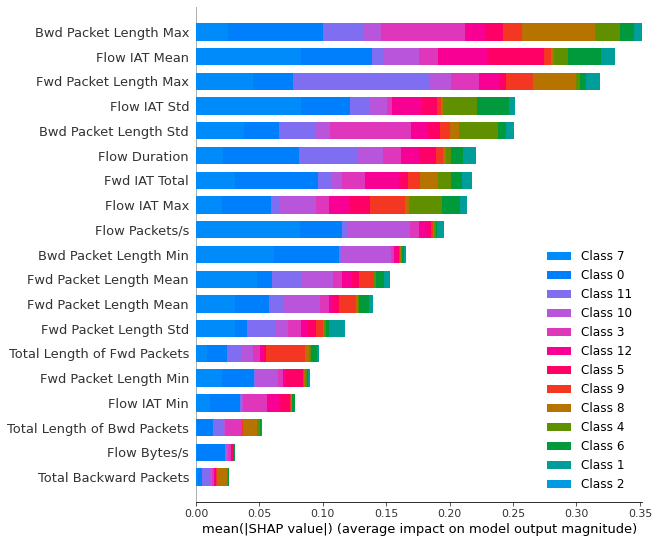

In [65]:
shap.summary_plot(shap_values, features=x_samples, feature_names=features)